Epoch 1: Loss = 5.6014
Epoch 2: Loss = 4.9651
Epoch 3: Loss = 4.9301
Epoch 4: Loss = 4.6303
Epoch 5: Loss = 4.5438
Epoch 6: Loss = 4.5224
Epoch 7: Loss = 4.6017
Epoch 8: Loss = 4.6388
Epoch 9: Loss = 4.4759
Epoch 10: Loss = 4.7481
Epoch 11: Loss = 4.5163
Epoch 12: Loss = 4.5177
Epoch 13: Loss = 4.8960
Epoch 14: Loss = 4.5802
Epoch 15: Loss = 4.4726
Epoch 16: Loss = 4.6880
Epoch 17: Loss = 4.3891
Epoch 18: Loss = 4.4027
Epoch 19: Loss = 4.4015
Epoch 20: Loss = 4.4095
Epoch 21: Loss = 4.4675
Epoch 22: Loss = 4.3882
Epoch 23: Loss = 4.3423
Epoch 24: Loss = 4.2535
Epoch 25: Loss = 4.2260
Epoch 26: Loss = 4.4060
Epoch 27: Loss = 4.2475
Epoch 28: Loss = 4.6056
Epoch 29: Loss = 4.4883
Epoch 30: Loss = 4.5885
Epoch 31: Loss = 4.6666
Epoch 32: Loss = 4.5734
Epoch 33: Loss = 4.5649
Epoch 34: Loss = 4.7003
Epoch 35: Loss = 4.7225
Epoch 36: Loss = 4.6191
Epoch 37: Loss = 4.3953
Epoch 38: Loss = 4.4843
Epoch 39: Loss = 4.4412
Epoch 40: Loss = 4.4954
Epoch 41: Loss = 4.5455
Epoch 42: Loss = 4.5118
E

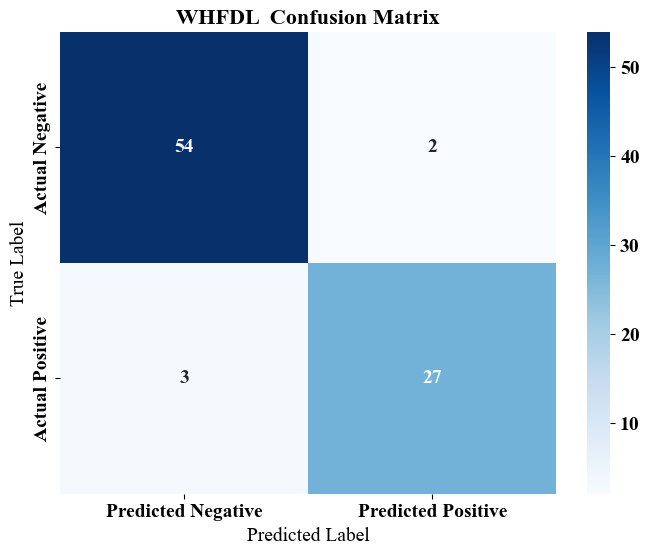

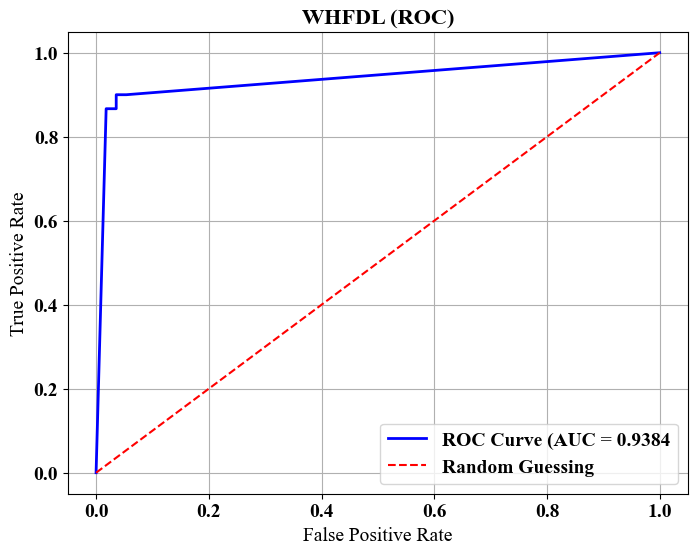

In [36]:
import torchvision
import torch
import torch.nn as nn
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from matplotlib import rcParams
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
import random  

rcParams['font.family'] = 'Times New Roman'

class FuzzyLayer(nn.Module):
    def __init__(self, in_features, num_memberships):
        super(FuzzyLayer, self).__init__()
        self.in_features = in_features
        self.num_memberships = num_memberships
        self.mu = nn.Parameter(torch.randn(num_memberships, in_features))
        self.sigma = nn.Parameter(torch.ones(num_memberships, in_features))

    def forward(self, a):
        a = a.unsqueeze(1)  
        mu = self.mu.unsqueeze(0) 
        sigma = self.sigma.unsqueeze(0) 
        fuzzy_out = torch.exp(-((a - mu) ** 2) / (sigma ** 2))
        return fuzzy_out

class NeuralRep(nn.Module):
    def __init__(self, in_features, hidden_dim=128, dropout_rate=0.1):
        super(NeuralRep, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)           
        x = torch.relu(self.fc2(x))
        return x

class FusionLayer(nn.Module):
    def __init__(self, in_features, hidden_dim, num_memberships):
        super(FusionLayer, self).__init__()
        self.output_dim = hidden_dim
        self.fusion = nn.Linear(num_memberships * in_features + hidden_dim, hidden_dim)

    def forward(self, fuzzy_out, neural_out):
        batch_size = fuzzy_out.size(0)
        fuzzy_flat = fuzzy_out.view(batch_size, -1)
        combined = torch.cat([fuzzy_flat, neural_out], dim=1)  
        return torch.relu(self.fusion(combined))

class Classifier(nn.Module):
    def __init__(self, hidden_dim, num_classes):
        super(Classifier, self).__init__()
        self.output = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        z = self.output(x)  
        return torch.softmax(z, dim=1)

class FDNN(nn.Module):
    def __init__(self, in_features, hidden_dim, num_memberships, num_classes, dropout_rate=0.1):
        super(FDNN, self).__init__()
        self.fuzzy = FuzzyLayer(in_features, num_memberships)
        self.neural = NeuralRep(in_features, hidden_dim, dropout_rate)
        self.fusion = FusionLayer(in_features, hidden_dim, num_memberships)
        self.classifier = Classifier(hidden_dim, num_classes)

    def forward(self, x):
        fuzzy_out = self.fuzzy(x)
        neural_out = self.neural(x)
        fusion_out = self.fusion(fuzzy_out, neural_out)
        return self.classifier(fusion_out)

def initialize_fuzzy_layer(fuzzy_layer, data_loader, num_samples=1000):
    all_inputs = []
    for batch_x, _ in data_loader:
        all_inputs.append(batch_x)
    all_inputs = torch.cat(all_inputs, dim=0)

    if all_inputs.shape[0] > num_samples:
        idx = torch.randperm(all_inputs.shape[0])[:num_samples]
        all_inputs = all_inputs[idx]

    inputs_np = all_inputs.numpy()
    kmeans = KMeans(n_clusters=fuzzy_layer.num_memberships, random_state=32)
    kmeans.fit(inputs_np)

    centers = kmeans.cluster_centers_  
    fuzzy_layer.mu.data = torch.tensor(centers, dtype=torch.float32)

    labels = kmeans.labels_
    sigmas = []
    for i in range(fuzzy_layer.num_memberships):
        cluster_points = inputs_np[labels == i]
        if len(cluster_points) > 1:
            distances = ((cluster_points - centers[i]) ** 2).mean(axis=0)
            sigma = distances ** 0.5
        else:
            sigma = np.ones(fuzzy_layer.in_features) * 0.1  
        sigmas.append(sigma)
    
    fuzzy_layer.sigma.data = torch.tensor(sigmas, dtype=torch.float32)

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)  

set_seed(42)

df = pd.read_csv('CGMAIN1.csv')
X = df.drop(columns='state').values
y = df['state'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = FDNN(
    in_features=X.shape[1],  
    hidden_dim=128,       
    num_memberships=3,     
    num_classes=len(np.unique(y)),        
    dropout_rate=0.1      
)

initialize_fuzzy_layer(model.fuzzy, train_loader)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(100):
    total_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

model.eval()  
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        outputs = model(x_batch)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_preds.extend(preds.numpy())
        all_probs.extend(probs[:, 1].numpy())  
        all_labels.extend(y_batch.numpy())

print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('WHFDL  Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('WHFDL (ROC)', fontsize=16, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

C:\Users\Arman\AppData\Local\Temp\ipykernel_12064\2449450982.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
C:\Users\Arman\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
C:\Users\Arman\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(

<Figure size 1400x1000 with 0 Axes>

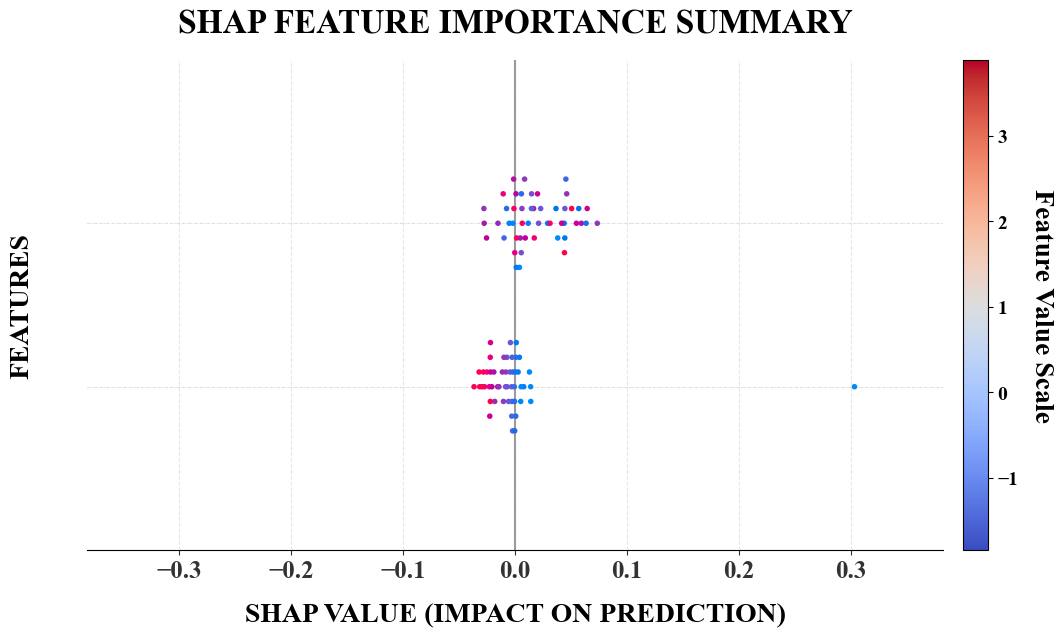

In [37]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Set model to evaluation mode
model.eval()

# Prepare SHAP explainer
background = X_tensor[:100].numpy()
explainer = shap.Explainer(model_predict, background)

# Calculate SHAP values
shap_values = explainer(X_tensor[:50].numpy())

# Create figure with custom styling
plt.figure(figsize=(14, 10))
plt.gcf().set_facecolor('white')

# Plot SHAP summary
shap.summary_plot(
    shap_values.values,
    features=X_tensor[:50].numpy(),
    feature_names=df.drop(columns='state').columns.tolist(),
    show=False,
    plot_size=None
)

# Professional colorbar with large bold fonts
norm = Normalize(vmin=np.min(background), vmax=np.max(background))
sm = ScalarMappable(norm=norm, cmap='coolwarm')
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02)
cbar.set_label('Feature Value Scale', 
               rotation=270, 
               labelpad=25,
               fontsize=20,
               fontweight='bold')

# Customize all text elements with size 20 and bold
plt.title('SHAP FEATURE IMPORTANCE SUMMARY', 
          fontsize=24,  # Slightly larger for title
          fontweight='bold', 
          pad=20)
plt.xlabel('SHAP VALUE (IMPACT ON PREDICTION)', 
           fontsize=20,
           fontweight='bold', 
           labelpad=15)
plt.ylabel('FEATURES', 
           fontsize=20,
           fontweight='bold', 
           labelpad=15)

# Modify tick labels to be bold and larger
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=18)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# Add grid
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

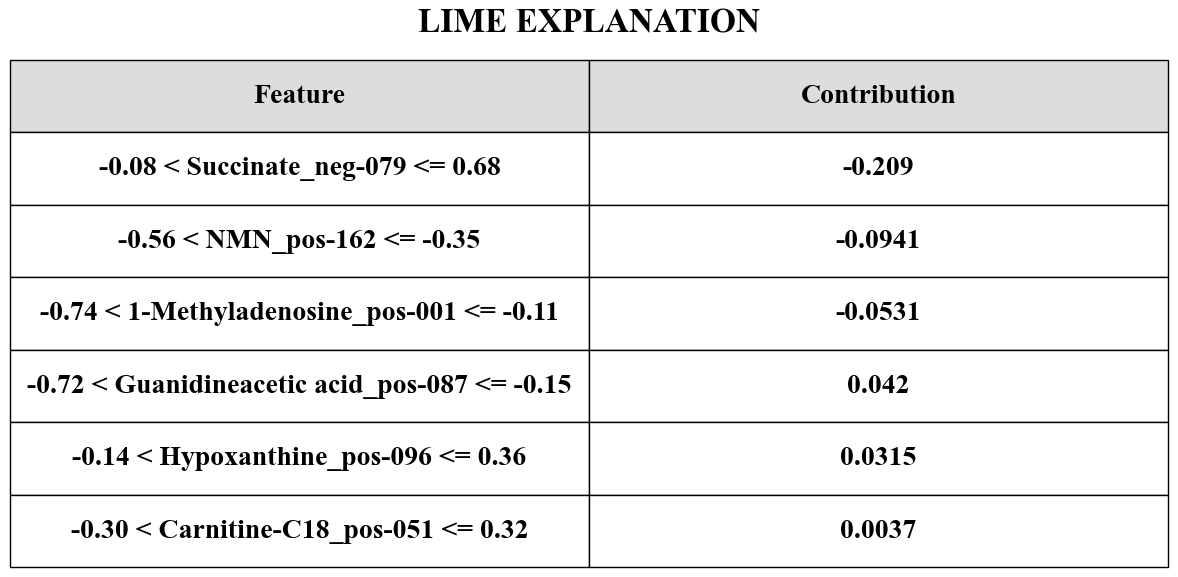

In [38]:
# ----- LIME Explanation -----
# Initialize LIME explainer
explainer_lime = LimeTabularExplainer(
    training_data=X,  # Training data features
    feature_names=df.drop(columns='state').columns.tolist(),  # Feature names
    class_names=['Negative', 'Positive'],  # Class labels
    mode='classification'  # Explanation mode
)

# Select sample to explain (first sample in this case)
sample_to_explain = X_tensor[0].numpy()

# Generate explanation for positive class (label=1)
exp = explainer_lime.explain_instance(
    sample_to_explain, 
    model_predict,  # Model prediction function
    num_features=10  # Top 10 features to show
)

# Convert explanation to dataframe
exp_list = exp.as_list(label=1)  # Get explanations for positive class
lime_df = pd.DataFrame(exp_list, columns=['Feature', 'Contribution'])
lime_df['Contribution'] = lime_df['Contribution'].round(4)  # Round contributions

# Create visualization with large fonts
plt.figure(figsize=(12, 6))  # Larger figure size
plt.gcf().set_facecolor('white')

# Create table with feature contributions
table = plt.table(
    cellText=lime_df.values,
    colLabels=lime_df.columns,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]  # Full figure bounding box
)

# Format table text - set all fonts to size 20 and bold
table.auto_set_font_size(False)
table.set_fontsize(20)
for (i, j), cell in table.get_celld().items():
    cell.set_text_props(fontweight='bold')
    if i == 0:  # Header row
        cell.set_facecolor('#dddddd')

plt.axis('off')  # Hide axes
plt.title('LIME EXPLANATION', 
          fontsize=24,  # Larger title
          fontweight='bold',
          pad=20)  # Add padding

plt.tight_layout()
plt.show()

Number of bins requested: 10
Number of bins returned: 2
Brier Score: 0.3409


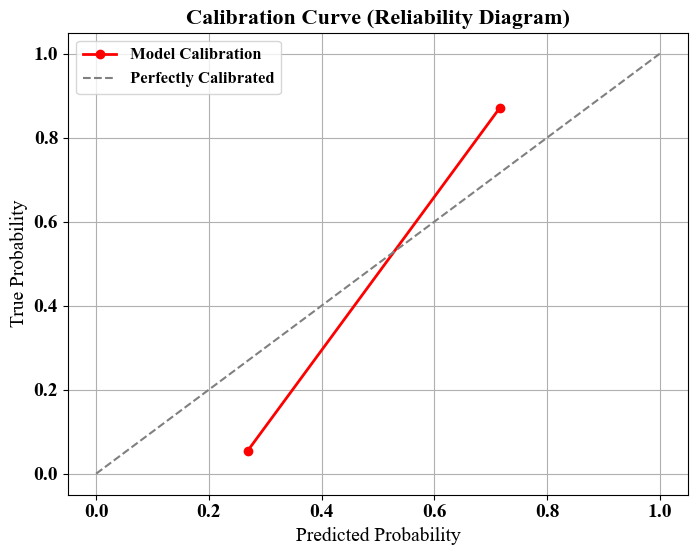

In [69]:
# Calibration Curve
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# --------- Load and Preprocess Data ---------
df = pd.read_csv('CGMAIN1.csv')
X = df.drop(columns='state').values
y = df['state'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# --------- Load the trained model (assume model is trained) ---------
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    probs = torch.softmax(outputs, dim=1)[:, 1].numpy()

# --------- Calibration Curve ---------
n_bins = 10
strategy = 'quantile'  

prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=n_bins, strategy=strategy)

print(f"Number of bins requested: {n_bins}")
print(f"Number of bins returned: {len(prob_true)}")
brier_score = brier_score_loss(y_true, y_prob)
print(f"Brier Score: {brier_score:.4f}")

# --------- Plotting Calibration Curve ---------
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', color='red', linewidth=2, label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability', fontsize=14)
plt.ylabel('True Probability', fontsize=14)
plt.title('Calibration Curve (Reliability Diagram)', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


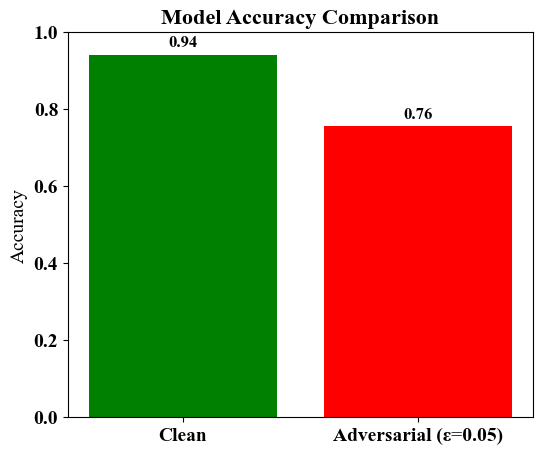

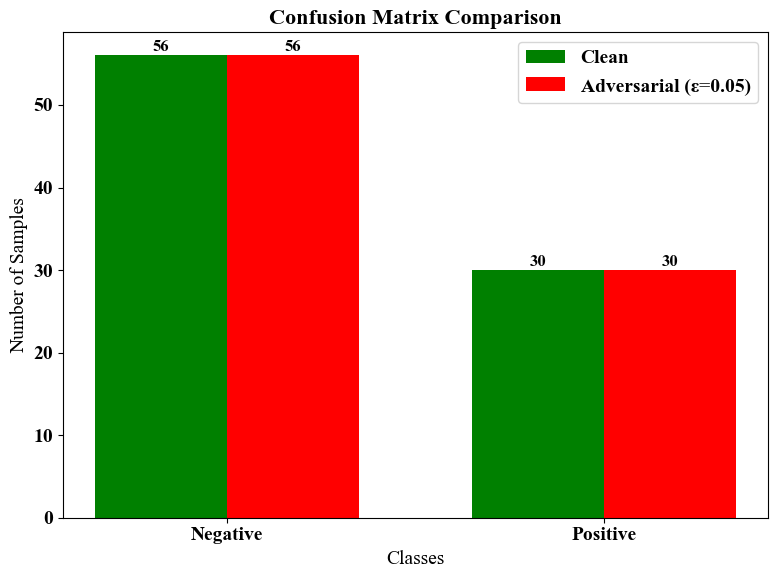

In [76]:
# adversarial vulnerability

import matplotlib.pyplot as plt
import numpy as np

# Accuracy values
acc_values = [acc_clean, acc_adv]
acc_labels = ['Clean', f'Adversarial (ε={epsilon})']

# Plot accuracy
plt.figure(figsize=(6, 5))
plt.bar(acc_labels, acc_values, color=['green', 'red'])
plt.ylim(0, 1)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
for i, v in enumerate(acc_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)
plt.show()

# Plot confusion matrix (stacked bar)
# Sum rows and columns for each confusion matrix
cm_clean_sum = cm_clean.sum(axis=1)
cm_adv_sum = cm_adv.sum(axis=1)

classes = ['Negative', 'Positive']  # Adjust as needed

x = np.arange(len(classes))
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(8, 6))
bar1 = ax.bar(x - width/2, cm_clean_sum, width, label='Clean', color='green')
bar2 = ax.bar(x + width/2, cm_adv_sum, width, label=f'Adversarial (ε={epsilon})', color='red')

ax.set_xlabel('Classes', fontsize=14)
ax.set_ylabel('Number of Samples', fontsize=14)
ax.set_title('Confusion Matrix Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Annotate bars
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', fontsize=12)

plt.tight_layout()
plt.show()


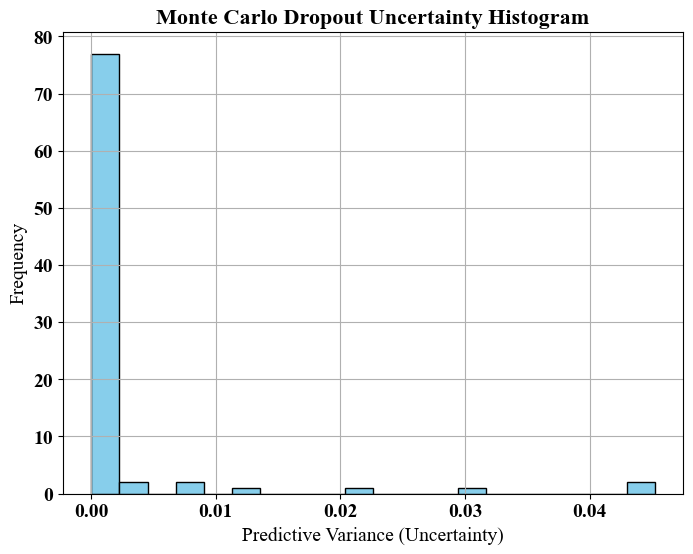

Sample 0: Mean Prob = 0.7311 | Variance = 0.000000
Sample 1: Mean Prob = 0.7291 | Variance = 0.000199
Sample 2: Mean Prob = 0.2689 | Variance = 0.000000
Sample 3: Mean Prob = 0.2689 | Variance = 0.000000
Sample 4: Mean Prob = 0.2689 | Variance = 0.000000


In [77]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Enable dropout during evaluation
def enable_dropout(model):
    """
    Function to enable dropout during inference
    """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

# Number of Monte Carlo forward passes
num_mc_samples = 50  # Can adjust to 30, 100, etc.

all_probs_mc = []

# Collect predictions
with torch.no_grad():
    for x_batch, _ in test_loader:
        mc_outputs = []
        for _ in range(num_mc_samples):
            enable_dropout(model)  # Activate dropout
            probs = model(x_batch)
            probs = torch.softmax(probs, dim=1)
            mc_outputs.append(probs.unsqueeze(0))
        
        # Stack predictions and compute mean and variance
        mc_outputs = torch.cat(mc_outputs, dim=0)  # [num_mc_samples, batch_size, num_classes]
        mean_probs = mc_outputs.mean(dim=0)  # [batch_size, num_classes]
        var_probs = mc_outputs.var(dim=0)    # [batch_size, num_classes]
        
        all_probs_mc.append((mean_probs, var_probs))

# Concatenate all batches
mean_probs_all = torch.cat([mp for mp, _ in all_probs_mc], dim=0)
var_probs_all = torch.cat([vp for _, vp in all_probs_mc], dim=0)

# Example for binary classification: plot uncertainty histogram
uncertainty = var_probs_all[:, 1].numpy()  # Assuming class 1 is positive

plt.figure(figsize=(8, 6))
plt.hist(uncertainty, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Predictive Variance (Uncertainty)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Monte Carlo Dropout Uncertainty Histogram', fontsize=16, fontweight='bold')
plt.grid(True)
plt.show()

# Optional: Print a few example predictions
for i in range(5):
    print(f"Sample {i}: Mean Prob = {mean_probs_all[i, 1]:.4f} | Variance = {var_probs_all[i, 1]:.6f}")
